In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/SC期货指数-Brent原油期货价格.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['SC期货指数-Brent原油期货价格'].last_valid_index()
 
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,SC期货指数-Brent原油期货价格,中国10年期国债收益率-美国10年期国债实际收益率20日环差,人民币汇率收盘价,汽油出口利润（华东-新加坡）,WESTPAC中国经济惊喜指数,SC仓单（百万桶）20日环差,中国主营炼油企业利润,SC期货指数-Brent原油期货价格Seasonal/F0.2/5DMA(预测/过去2年季节性),Kpler-中国原油浮仓超季节性/3年,柴油EW价差超季节性/3年,低硫燃料油EW价差,VLCC运费（沙特-新加坡）超季节性/3年,GPR地缘风险指数/自动/7DMA20日环差,中国原油总库存可用天数超季节性/3年
2025-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0688,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.8124,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.9028,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5455,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.3112,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths = [
    os.path.expanduser("~/Desktop/X-BASE/宏观经济/eta/USDCNY即期汇率_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/宏观经济/eta/USDCNY即期汇率_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/宏观经济/eta/USDCNY即期汇率_合并数据.xlsx")
]

file_path = None
for path in file_paths:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path = path
        break

if file_path is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['真实值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()

,Date,预测值
19,2025-11-03,7.1150
18,2025-11-04,7.1173
17,2025-11-05,7.1226
16,2025-11-06,7.1271
15,2025-11-07,7.1399


In [6]:
sheet3 = pd.ExcelFile('eta/汽油出口利润-华东-新加坡_合并数据.xlsx').parse('Sheet1')
sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
sheet3 = sheet3.sort_values('Date', ascending=True)
sheet3 = sheet3.drop(columns=['真实值'])
sheet3 = sheet3.dropna()
sheet3.head()

,Date,预测值
29,2025-11-03,659.3
28,2025-11-04,663.1
27,2025-11-05,661.4
26,2025-11-06,518.2
25,2025-11-07,325.2


In [7]:
sheet.tail()

,SC期货指数-Brent原油期货价格,中国10年期国债收益率-美国10年期国债实际收益率20日环差,人民币汇率收盘价,汽油出口利润（华东-新加坡）,WESTPAC中国经济惊喜指数,SC仓单（百万桶）20日环差,中国主营炼油企业利润,SC期货指数-Brent原油期货价格Seasonal/F0.2/5DMA(预测/过去2年季节性),Kpler-中国原油浮仓超季节性/3年,柴油EW价差超季节性/3年,低硫燃料油EW价差,VLCC运费（沙特-新加坡）超季节性/3年,GPR地缘风险指数/自动/7DMA20日环差,中国原油总库存可用天数超季节性/3年
2025-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0688,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.8124,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.9028,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5455,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.3112,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['人民币汇率收盘价'] = sheet_daily['人民币汇率收盘价'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', '预测值']].assign(预测值=lambda x: x['预测值'].rolling(5).mean()),
    on='Date',
    how='left'
)
sheet_daily['汽油出口利润（华东-新加坡）'] = sheet_daily['汽油出口利润（华东-新加坡）'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [9]:
sheet.columns

Index(['SC期货指数-Brent原油期货价格', '中国10年期国债收益率-美国10年期国债实际收益率20日环差', '人民币汇率收盘价',
       '汽油出口利润（华东-新加坡）', 'WESTPAC中国经济惊喜指数', 'SC仓单（百万桶）20日环差', '中国主营炼油企业利润',
       'SC期货指数-Brent原油期货价格Seasonal/F0.2/5DMA(预测/过去2年季节性)',
       'Kpler-中国原油浮仓超季节性/3年', '柴油EW价差超季节性/3年', '低硫燃料油EW价差',
       'VLCC运费（沙特-新加坡）超季节性/3年', 'GPR地缘风险指数/自动/7DMA20日环差',
       '中国原油总库存可用天数超季节性/3年'],
      dtype='object')

In [10]:
################################# 处理缺失值 #################################
fill_methods = {
'中国10年期国债收益率-美国10年期国债实际收益率20日环差': 'interpolate', 
'人民币汇率收盘价': 'interpolate',
'汽油出口利润（华东-新加坡）': 'interpolate', 
'WESTPAC中国经济惊喜指数': 'interpolate',
'SC仓单（百万桶）20日环差': 'interpolate', 
'中国主营炼油企业利润': 'interpolate',
'Kpler-中国原油浮仓超季节性/3年': 'interpolate',
'柴油EW价差超季节性/3年': 'interpolate',
'低硫燃料油EW价差': 'interpolate',
'VLCC运费（沙特-新加坡）超季节性/3年': 'interpolate',
'GPR地缘风险指数/自动/7DMA20日环差':'interpolate',
'中国原油总库存可用天数超季节性/3年':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '汽油出口利润（华东-新加坡）'] = sheet.loc[:last_day, '汽油出口利润（华东-新加坡）'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['中国10年期国债收益率-美国10年期国债实际收益率20日环差_提前20天'] = sheet['中国10年期国债收益率-美国10年期国债实际收益率20日环差'].shift(20)
sheet['WESTPAC中国经济惊喜指数_提前20天'] = sheet['WESTPAC中国经济惊喜指数'].shift(20)
sheet['SC仓单（百万桶）20日环差_提前20天'] = sheet['SC仓单（百万桶）20日环差'].shift(20)
sheet['中国主营炼油企业利润_提前20天'] = sheet['中国主营炼油企业利润'].shift(20)
sheet['Kpler-中国原油浮仓超季节性/3年_提前10天'] = sheet['Kpler-中国原油浮仓超季节性/3年'].shift(10)
sheet['柴油EW价差超季节性/3年_提前20天'] = sheet['柴油EW价差超季节性/3年'].shift(20)
sheet['低硫燃料油EW价差_提前10天'] = sheet['低硫燃料油EW价差'].shift(10)
sheet['VLCC运费（沙特-新加坡）超季节性/3年_提前5天'] = sheet['VLCC运费（沙特-新加坡）超季节性/3年'].shift(5)
sheet['GPR地缘风险指数/自动/7DMA20日环差_提前10天'] = sheet['GPR地缘风险指数/自动/7DMA20日环差'].shift(10)
sheet['中国原油总库存可用天数超季节性/3年_提前13天'] = sheet['中国原油总库存可用天数超季节性/3年'].shift(13)

sheet['中国10年期国债收益率-美国10年期国债实际收益率20日环差_提前20天_逆序'] = reverse_column(sheet, '中国10年期国债收益率-美国10年期国债实际收益率20日环差_提前20天')
sheet['Kpler-中国原油浮仓超季节性/3年_提前10天_逆序'] = reverse_column(sheet, 'Kpler-中国原油浮仓超季节性/3年_提前10天')
sheet['中国原油总库存可用天数超季节性/3年_提前13天_逆序'] = reverse_column(sheet, '中国原油总库存可用天数超季节性/3年_提前13天')
# 获取最后20个数据点
last_20_points = sheet.tail(20)

# 处理每一列
for col in ['中国原油总库存可用天数超季节性/3年_提前13天_逆序']:
    # 找出重复值
    duplicates = last_20_points[col][last_20_points[col].duplicated(keep='first')]
    # 如果重复值超过3个,保留第一个出现的值,其他置为空
    if len(duplicates) >= 3:
        sheet.loc[sheet.index[-20:], col] = sheet.loc[sheet.index[-20:], col].mask(
            lambda x: x.duplicated(keep='first')
        )

sheet[['中国原油总库存可用天数超季节性/3年_提前13天_逆序','VLCC运费（沙特-新加坡）超季节性/3年_提前5天','GPR地缘风险指数/自动/7DMA20日环差_提前10天','低硫燃料油EW价差_提前10天']]
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['SC期货指数-Brent原油期货价格'].notna())
]

################################# 数据 读取-处理 结束 #################################

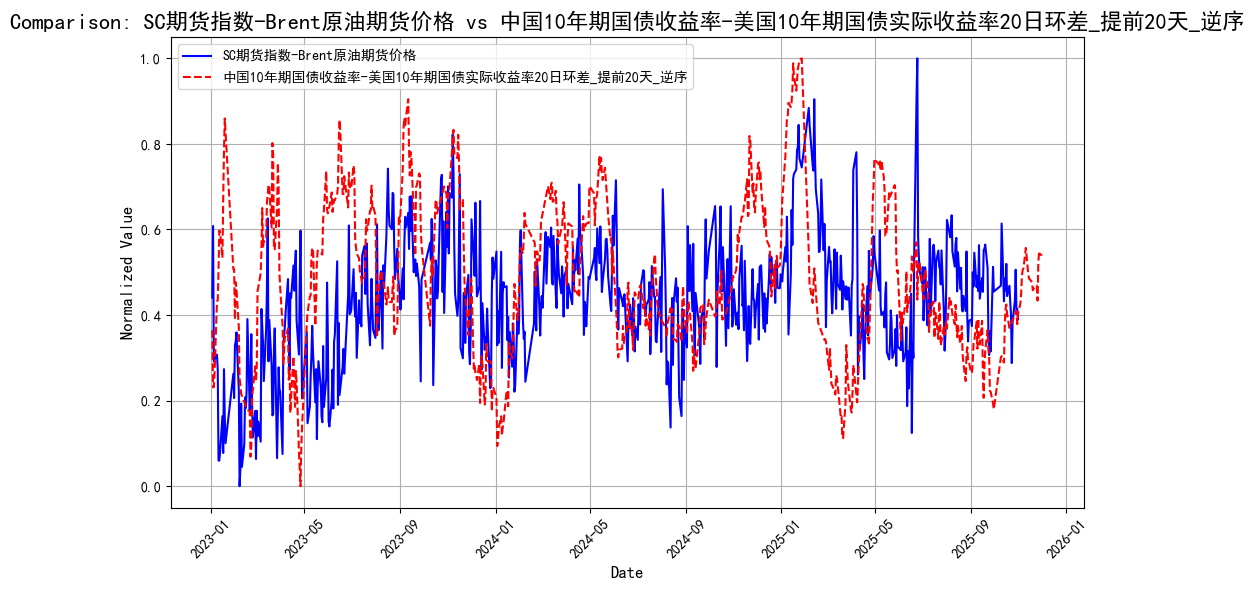

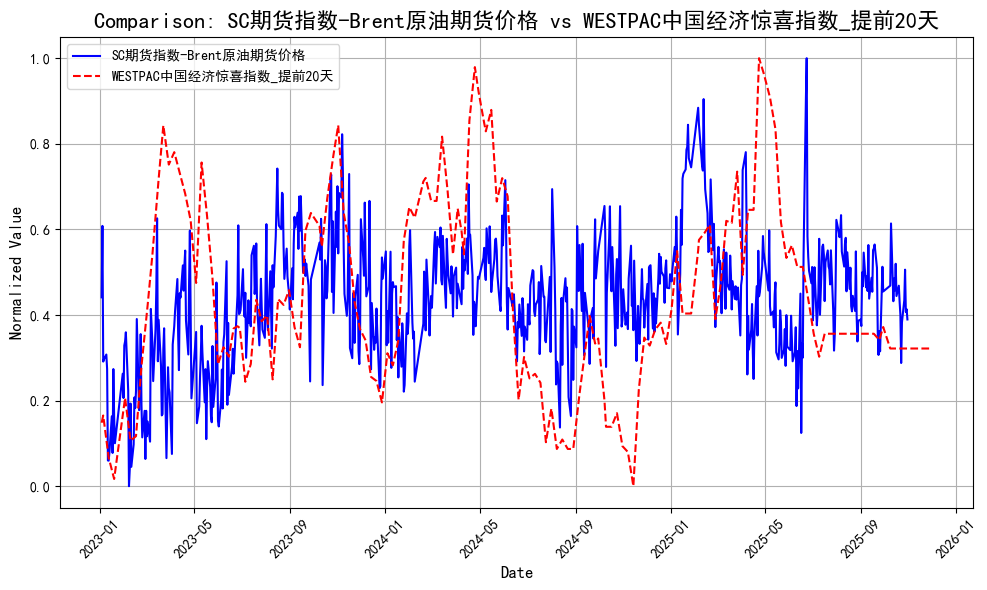

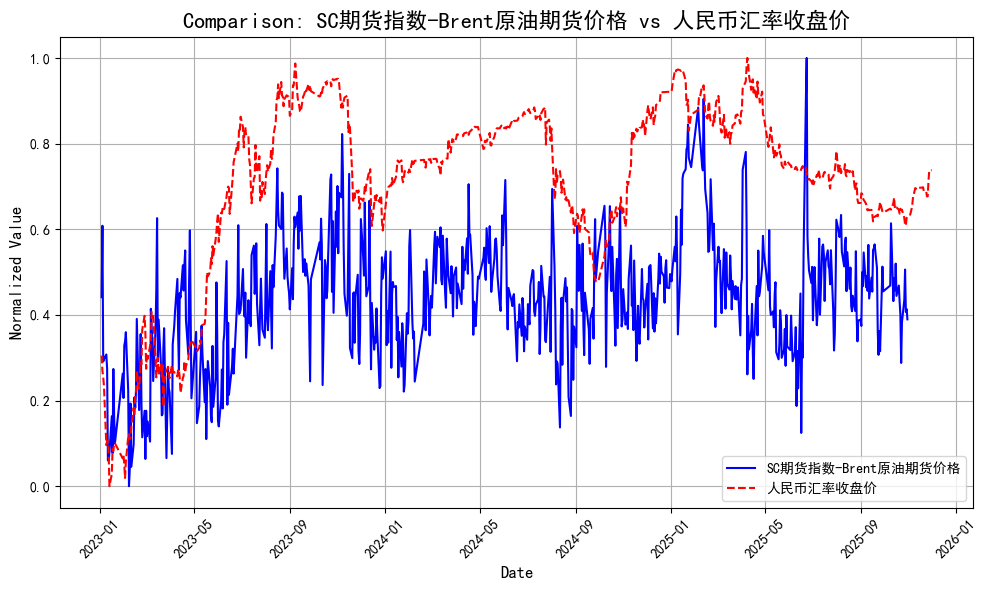

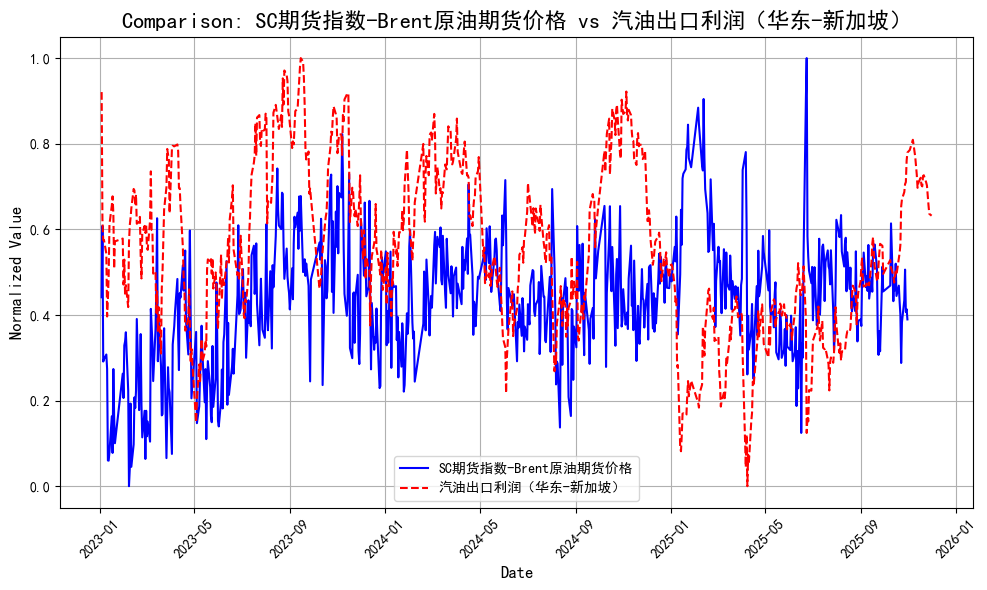

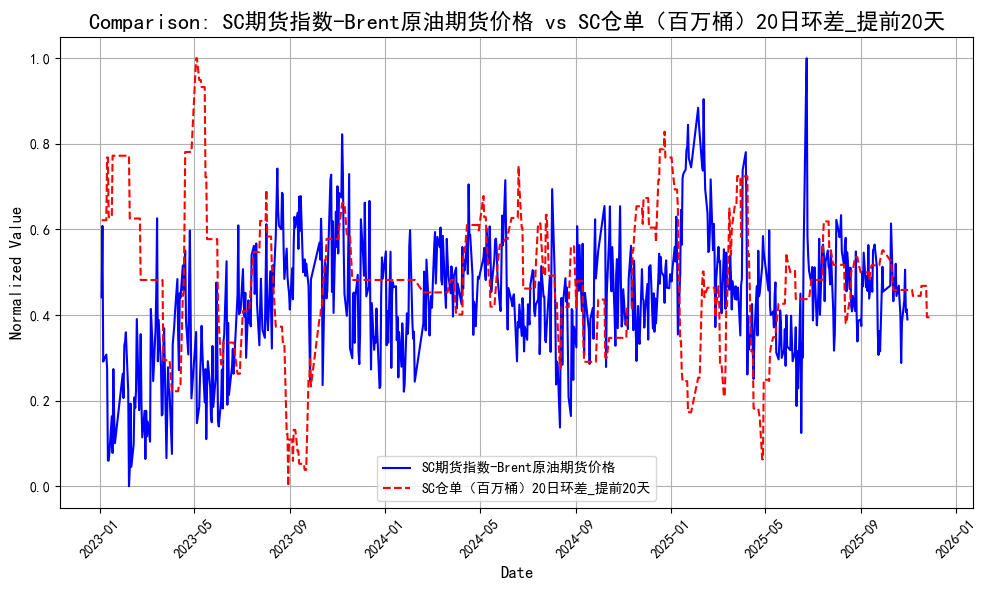

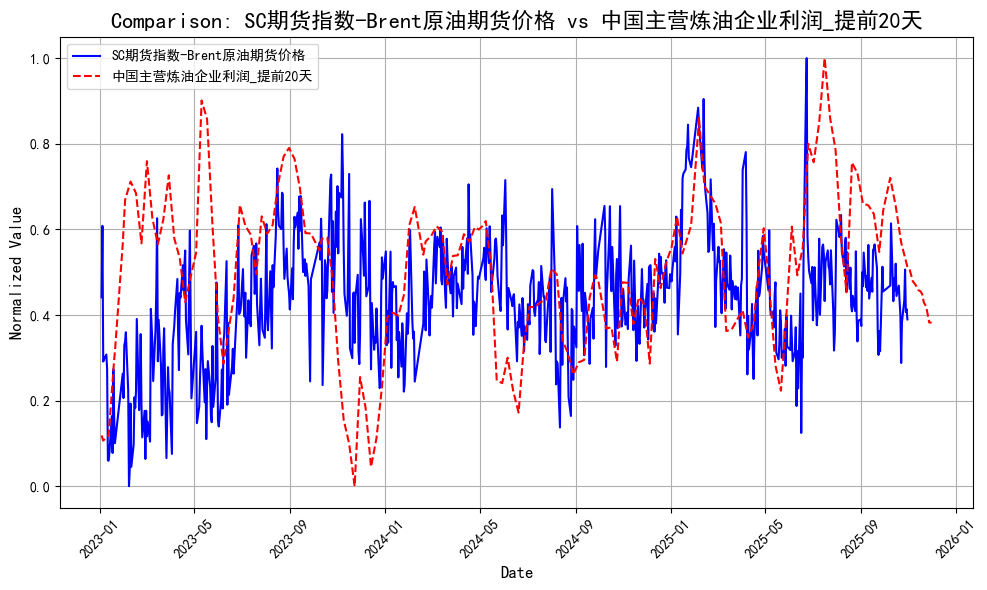

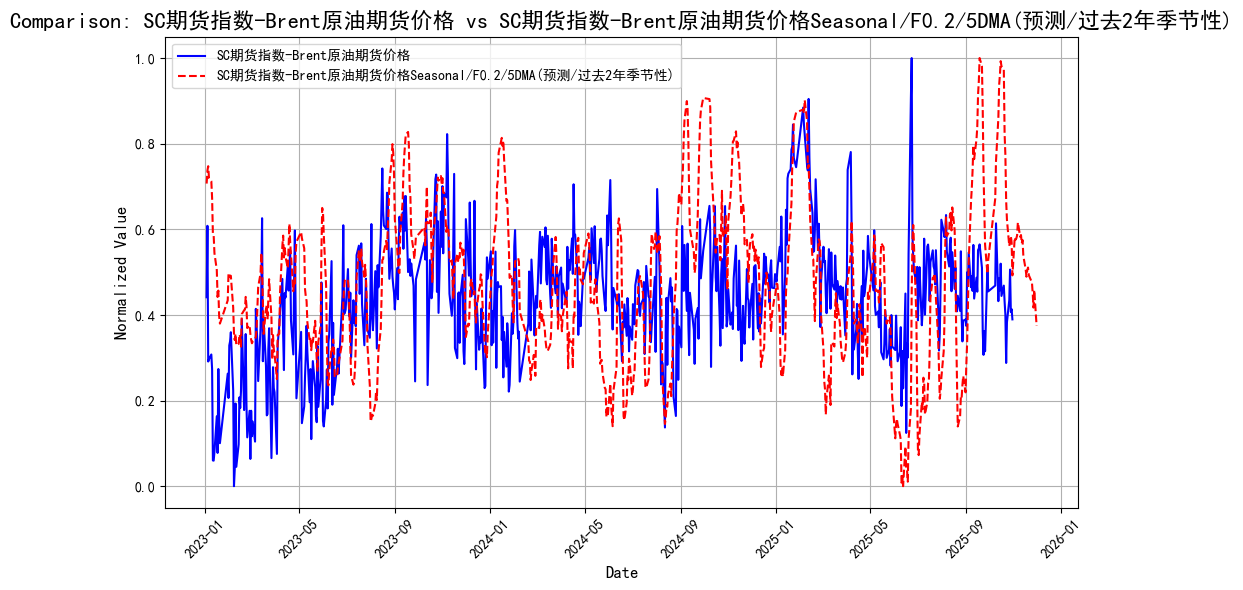

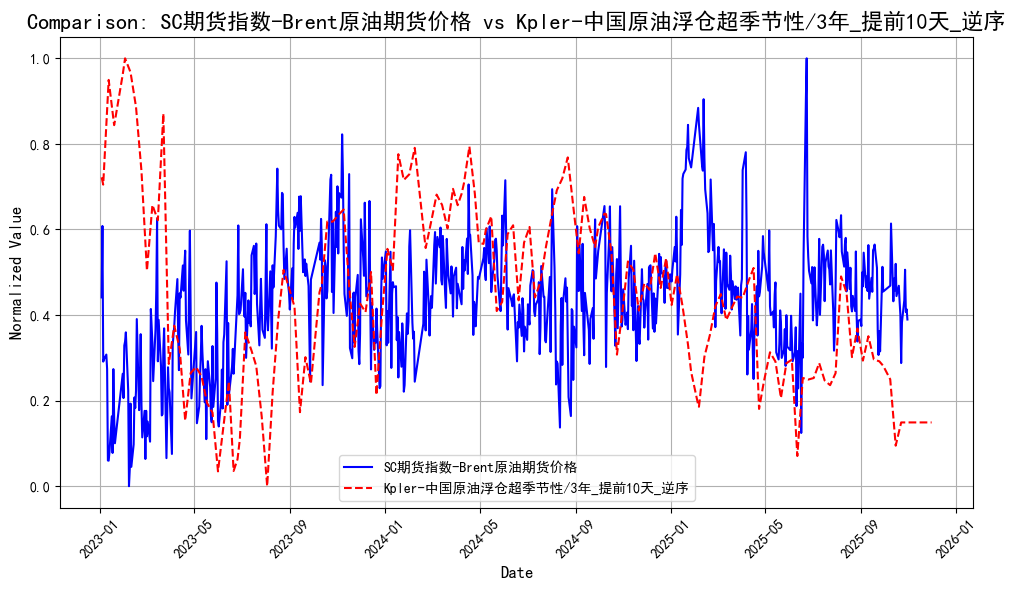

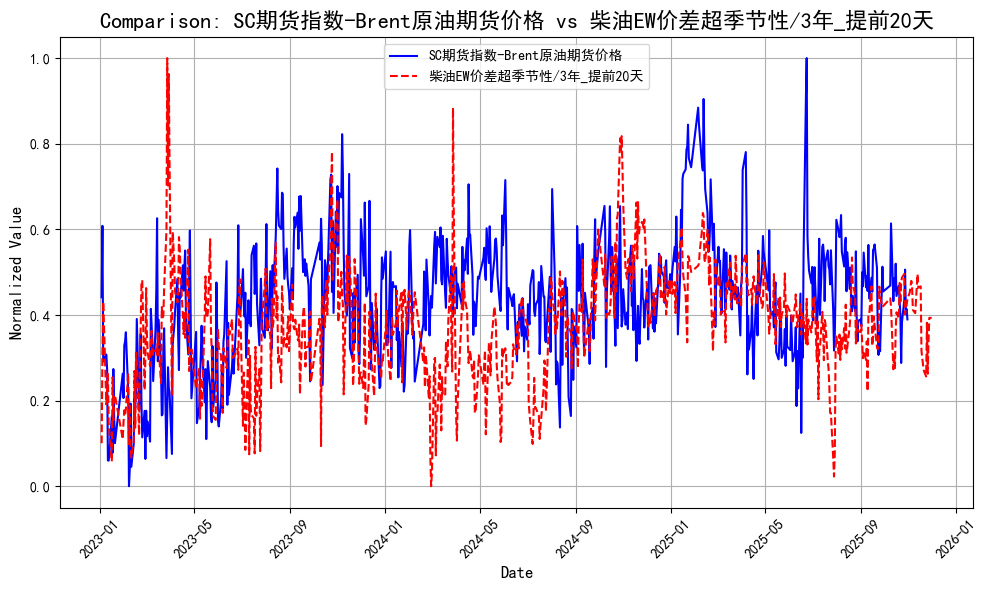

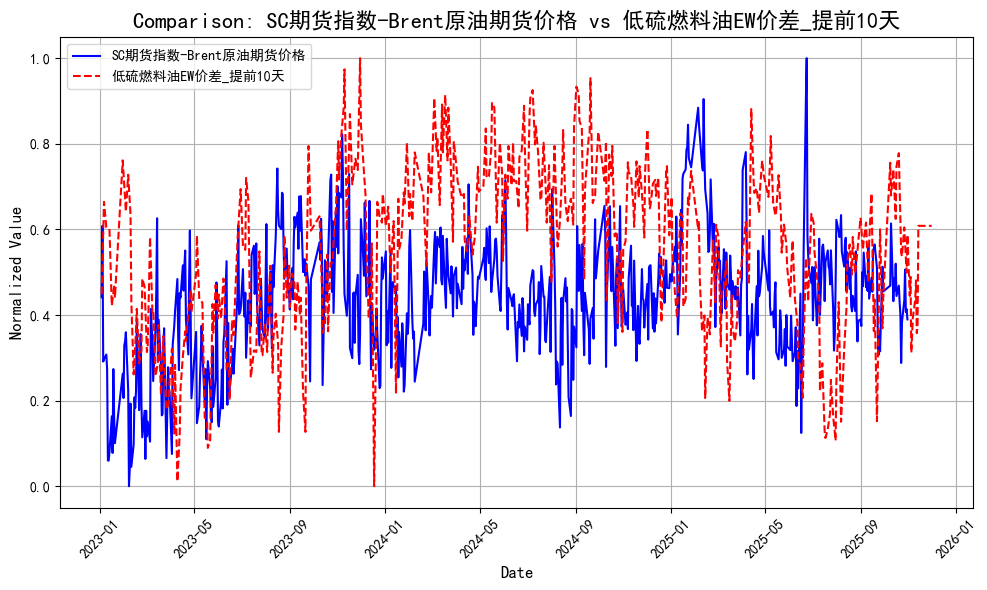

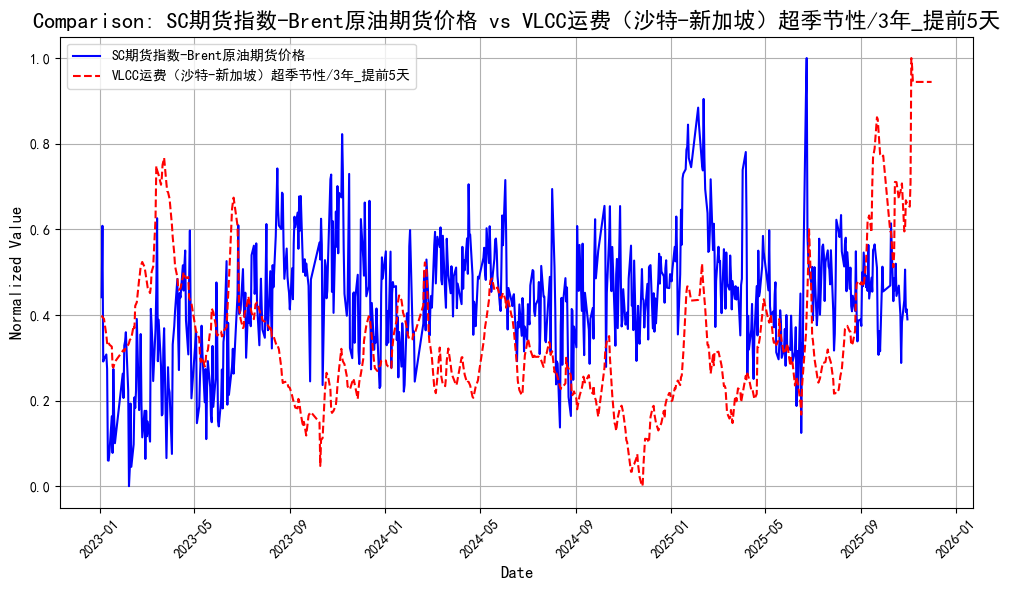

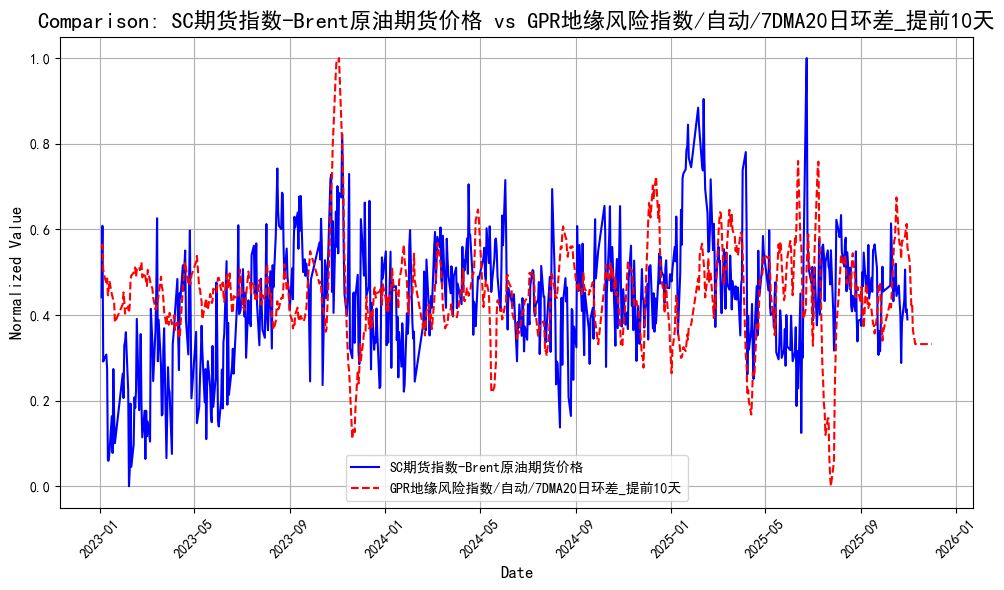

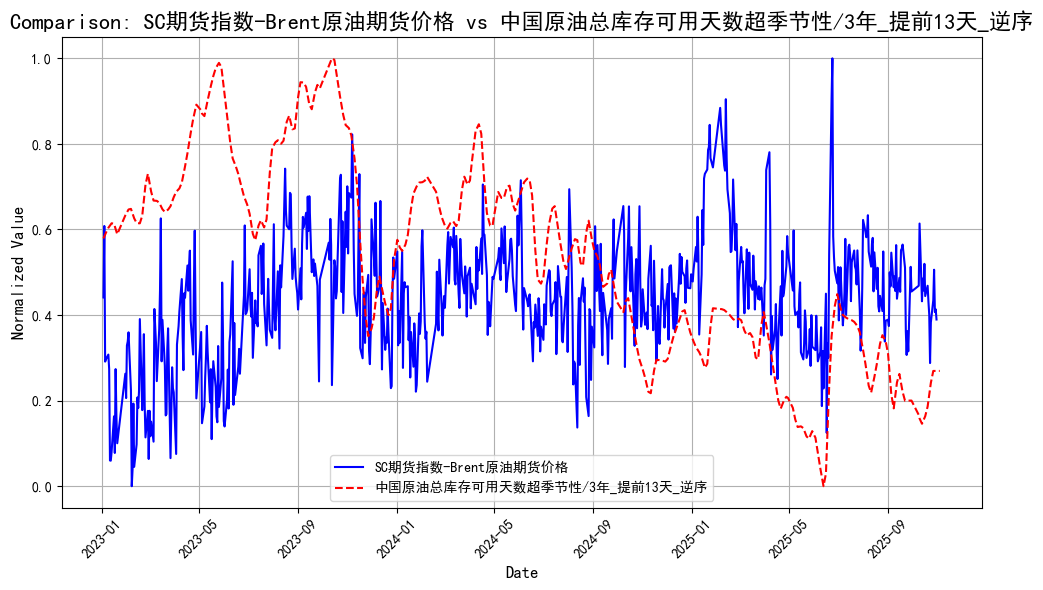

In [11]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='SC期货指数-Brent原油期货价格', 
    compare_cols=[
        '中国10年期国债收益率-美国10年期国债实际收益率20日环差_提前20天_逆序',
        'WESTPAC中国经济惊喜指数_提前20天',
        '人民币汇率收盘价',
        '汽油出口利润（华东-新加坡）',
        'SC仓单（百万桶）20日环差_提前20天',
        '中国主营炼油企业利润_提前20天',
        'SC期货指数-Brent原油期货价格Seasonal/F0.2/5DMA(预测/过去2年季节性)',
        'Kpler-中国原油浮仓超季节性/3年_提前10天_逆序',
        '柴油EW价差超季节性/3年_提前20天',
        '低硫燃料油EW价差_提前10天',
        'VLCC运费（沙特-新加坡）超季节性/3年_提前5天',
        'GPR地缘风险指数/自动/7DMA20日环差_提前10天',
        '中国原油总库存可用天数超季节性/3年_提前13天_逆序'
        ]
)

In [12]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 60
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
    '中国10年期国债收益率-美国10年期国债实际收益率20日环差_提前20天_逆序',
    'WESTPAC中国经济惊喜指数_提前20天',
    '人民币汇率收盘价',
    '汽油出口利润（华东-新加坡）',
    'SC仓单（百万桶）20日环差_提前20天',
    '中国主营炼油企业利润_提前20天',
    'SC期货指数-Brent原油期货价格Seasonal/F0.2/5DMA(预测/过去2年季节性)',
    'Kpler-中国原油浮仓超季节性/3年_提前10天_逆序',
  #  '柴油EW价差超季节性/3年_提前20天',
 #   '低硫燃料油EW价差_提前10天',
    'VLCC运费（沙特-新加坡）超季节性/3年_提前5天',
    'GPR地缘风险指数/自动/7DMA20日环差_提前10天',
    '中国原油总库存可用天数超季节性/3年_提前13天_逆序'
]

predict_column = 'SC期货指数-Brent原油期货价格'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.1,  # 默认学习率
    'max_depth': 7,  # 默认树深度
    'min_child_weight': 4,  # 默认最小子节点权重
    'subsample': 0.8,  # 默认子采样比例
    'colsample_bytree': 0.8,  # 默认特征采样比例
    'gamma': 1,  # 默认最小分裂损失
    'reg_alpha': 0.5,  # 默认L1正则化
    'reg_lambda': 3,  # 默认L2正则化
    'eval_metric': 'rmse',  # 评估指标
    'seed': 42,  # 随机种子
#    'tree_method': 'auto'  # 默认树方法
}


num_boost_round = 3000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:9.26261	train-rmse:13.94755


[500]	eval-rmse:8.92434	train-rmse:0.68172


[1000]	eval-rmse:8.92580	train-rmse:0.64939


[1500]	eval-rmse:8.93667	train-rmse:0.63527

[2000]	eval-rmse:8.93587	train-rmse:0.61822


[2500]	eval-rmse:8.94787	train-rmse:0.61217


[2999]	eval-rmse:8.94373	train-rmse:0.60541


训练集 MSE (DMatrix): 0.4007, 训练集 R² (DMatrix): 0.9983
测试集 MSE (DMatrix): 79.9902, 测试集 R² (DMatrix): -0.1074


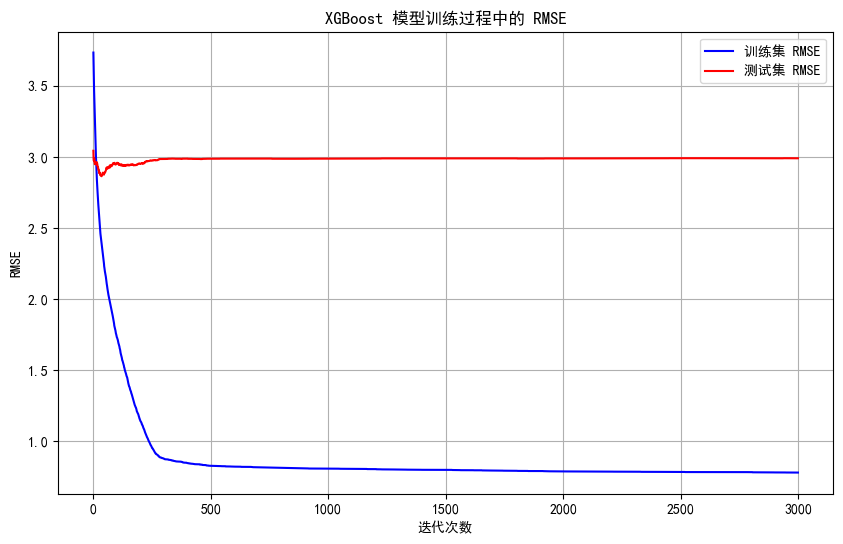

In [13]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:13.57277


[500]	train-rmse:0.68812


[1000]	train-rmse:0.64960


[1500]	train-rmse:0.63489


[2000]	train-rmse:0.62162


[2500]	train-rmse:0.61651


[2999]	train-rmse:0.61140


全部数据 MSE: 0.4027, 全部数据 R²: 0.9982


Gap between last actual value and first prediction: -2.3022134145736692


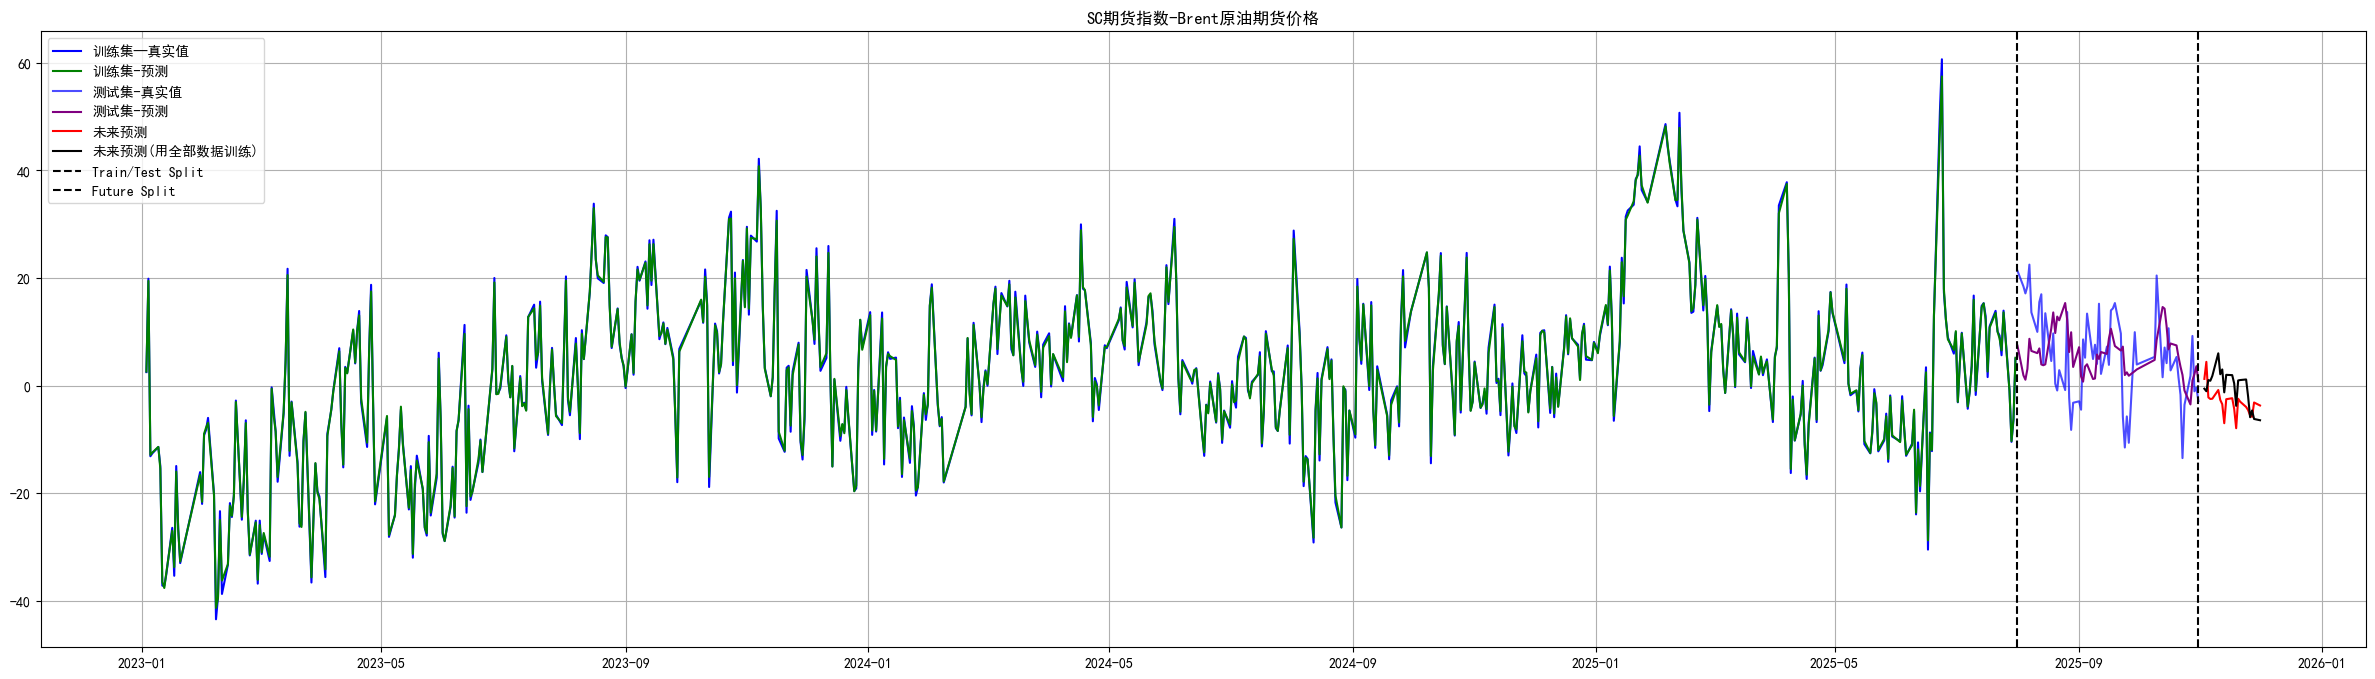

In [15]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('SC期货指数-Brent原油期货价格')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/SC期货指数-Brent原油期货价格_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
704,2025/12/01,NaN,-6.449183
703,2025/11/28,NaN,-6.210405
702,2025/11/27,NaN,-4.635987
701,2025/11/26,NaN,-5.888284
700,2025/11/25,NaN,-2.037974
...,...,...,...
4,2023/01/09,-11.4261,NaN
3,2023/01/06,-12.5959,NaN
2,2023/01/05,-13.1442,NaN
1,2023/01/04,19.8662,NaN


In [17]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 删除真实值和预测值都为空的行
merged_df_monthly = merged_df_monthly.dropna(subset=['真实值', '预测值'], how='all')

# 保存成excel
merged_df_monthly.to_excel('eta/SC期货指数-Brent原油期货价格_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly.head()

,Date,真实值,预测值
35,2025/12/31,NaN,-6.449183
34,2025/11/30,NaN,-0.161092
33,2025/10/31,2.746206,5.232410
32,2025/09/30,4.464868,4.711556
31,2025/08/31,8.903457,7.585217


In [18]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "SC期货指数-Brent原油期货价格"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [19]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "SC期货指数-Brent原油期货价格"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
